In [1]:
from dotenv import load_dotenv
import os
load_dotenv()
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini")


In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


# Add a State of the Graph

The first thing you do when you define a graph is define the State of the graph. 



# What is State of Graph?

The State consists of 2 things:
1. The schema of the graph 
2. A reducer functions which specify how to apply updates to the state. 



# State definition in our example

```State``` is a dictionary that inherits from ```TypedDict```.

```messages``` is a key in that dictionary ```State```. 

The value for this key is a list and it uses "Annotated" type hint.
The messages key is annotated with the add_messages reducer function.

This annotation which tells LangGraph to append new messages to the existing list, rather than overwriting it. 

State keys without an annotation will be overwritten by each update, storing the most recent value. 



In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Way to understand the concept of State Update
So basically when we say "updating" the ```State``` -> we essentially in this case means updating the list of messages in key ```messages```

# Create the StateGraph instance

create an instance of a StateGraph using the State class as its argument.



In [4]:
graph_builder = StateGraph(State)

# So now our graph knows two things:

1. Every node we define will receive the current ```State``` as input and return a value that updates that state.
2. Messages will be appended to the current list, rather than directly overwritten. 
3. This is communicated via the prebuilt ```add_messages``` function in the Annotated syntax.

# Add a "chatbot" node. 


Nodes represent units of work. They are typically regular python functions.


This chatbot node function takes the current ```State``` as input and returns a dictionary containing an updated ```messages``` list under the key "messages".

This is the basic pattern for all LangGraph node functions.

The ```add_messages``` function in our ```State``` will append the llm's response messages to whatever messages are already in the state.

In [5]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# Add the node to the graph

In [6]:
graph_builder.add_node("chatbot", chatbot)

# Add an entry point. 

This tells our graph where to start its work each time we run it.

In [7]:
graph_builder.add_edge(START, "chatbot")


# set a finish point. 

Similarly, set a finish point. This instructs the graph "**any time this node is run, you can exit**."

In [8]:
graph_builder.add_edge("chatbot", END)

Finally, we'll want to be able to run our graph. To do so, call ```compile()``` on the graph builder. This creates a ```"CompiledGraph"``` we can use invoke on our state.

In [9]:
graph = graph_builder.compile()

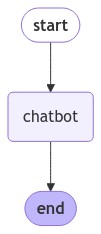

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# Invoke the graph

In [26]:
user_input = "Who is Elon Musk? Tell me in 10 words"

In [13]:
response=graph.invoke({"messages": ("user", user_input)})

# Note: The output of this grap again would be a state.

A dictionary containing a key 'messages' with a value that is a list. The list contains the list of messages.

In [14]:
response

{'messages': [HumanMessage(content='Who is Elon Musk? Tell me in 10 words', id='242babea-26a1-4abc-830f-9c9a3c2330cd'),
  AIMessage(content='Elon Musk is a billionaire entrepreneur, CEO, and inventor.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 18, 'total_tokens': 31, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f85bea6784', 'finish_reason': 'stop', 'logprobs': None}, id='run-dd9a1cdf-01ea-413f-bfda-a4428073ad33-0', usage_metadata={'input_tokens': 18, 'output_tokens': 13, 'total_tokens': 31})]}

In [17]:
type(response)

langgraph.pregel.io.AddableValuesDict

In [18]:
response["messages"][1].content

'Elon Musk is a billionaire entrepreneur, CEO, and inventor.'

# Streaming

In [27]:
stream_response=graph.stream({"messages": ("user", user_input)})

In [28]:
type(stream_response)

generator

In [30]:
for event in stream_response:
    print(type(event))

    for value in event.values():
        print("Assistant: ",value["messages"][-1].content)

# For streaming output in a loop

In [15]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [16]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Elon Musk is a prominent entrepreneur and business magnate known for his role in several high-profile technology companies. Born on June 28, 1971, in Pretoria, South Africa, he moved to the United States to attend the University of Pennsylvania, where he earned degrees in both physics and economics.

Musk is best known as the CEO and lead designer of SpaceX, a private aerospace manufacturer and space transportation company he founded in 2002. SpaceX has gained significant attention for its ambitious goals, including reducing space transportation costs and enabling the colonization of Mars. The company has successfully developed the Falcon and Starship rockets, as well as the Dragon spacecraft.

In addition to SpaceX, Musk is the CEO and product architect of Tesla, Inc., an electric vehicle and clean energy company he joined in 2004. Under his leadership, Tesla has become a leader in electric vehicles, producing popular models like the Model S, Model 3, Model X, and Model Y. 